In [24]:
from functools import partial

import pandas as pd

import src.utils as utils

In [25]:
metrics = utils.load_all_metric_files()

In [26]:
# This automatically picks the latest month in the data as the reporting period but you
# can replace the line to manually specify any month you choose.
# For example: `month_to_report = pd.Period("2023-06", freq="M")`
month_to_report = metrics.index[-1]

calculate_report = partial(utils.calc_rpt, reporting_period=month_to_report)
format_report = partial(utils.format_report, reporting_period=month_to_report)

## Essential metrics report

In [27]:
essential_metrics = [
    "interactions",
    "unique_devices",
    "northern_western_europe_unique_devices",
    "north_america_unique_devices",
    "east_southeast_asia_pacific_unique_devices",
    "central_eastern_europe_central_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "middle_east_north_africa_unique_devices",
    "south_asia_unique_devices",
    "subsaharan_africa_unique_devices",
    "active_editors",
    "returning_active_editors",
    "new_active_editors",
    "net_new_Wikipedia_articles",
    "net_new_Commons_content_pages",
    "net_new_Wikidata_entities",
]

(
    metrics
    .reindex(essential_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="essential")

)

## Core annual plan metrics report

In [28]:
core_metrics = [
    # % new quality biography articles about women and gender-diverse people
    # % new quality articles about regions that are underrepresented, compared to world population
    "unique_devices",
    "south_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "north_america_unique_devices",
    "northern_western_europe_unique_devices"
]

(
    metrics
    .reindex(core_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="core")
)

## Core annual plan and essential metric charts

Changing directory to:/srv/home/hghani/2023-11-08/wikicharts
Generating Content Interactions chart...


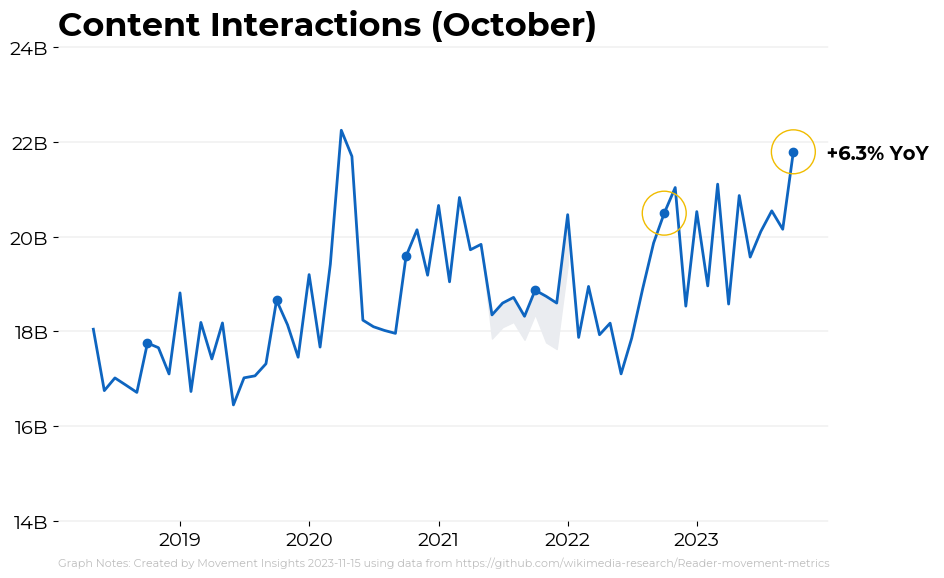

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


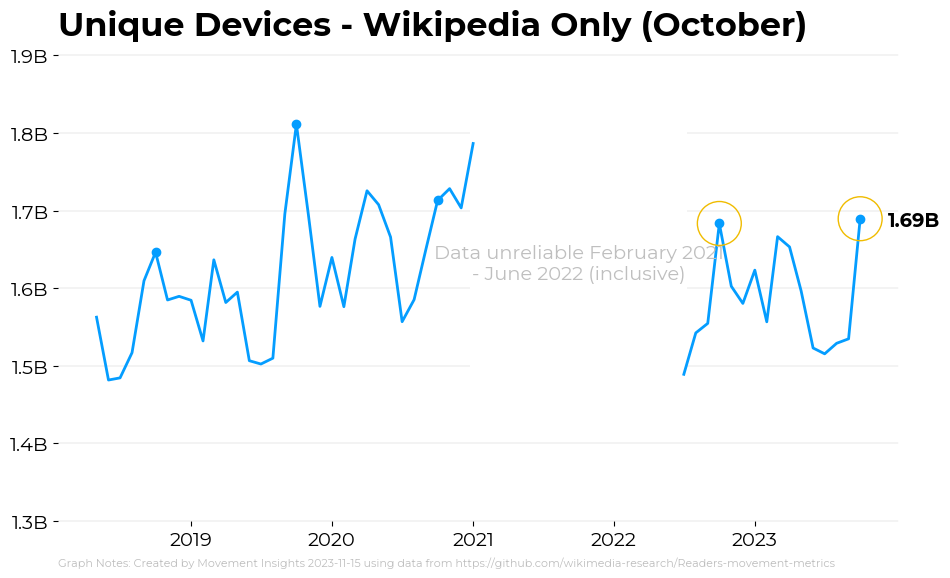

Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


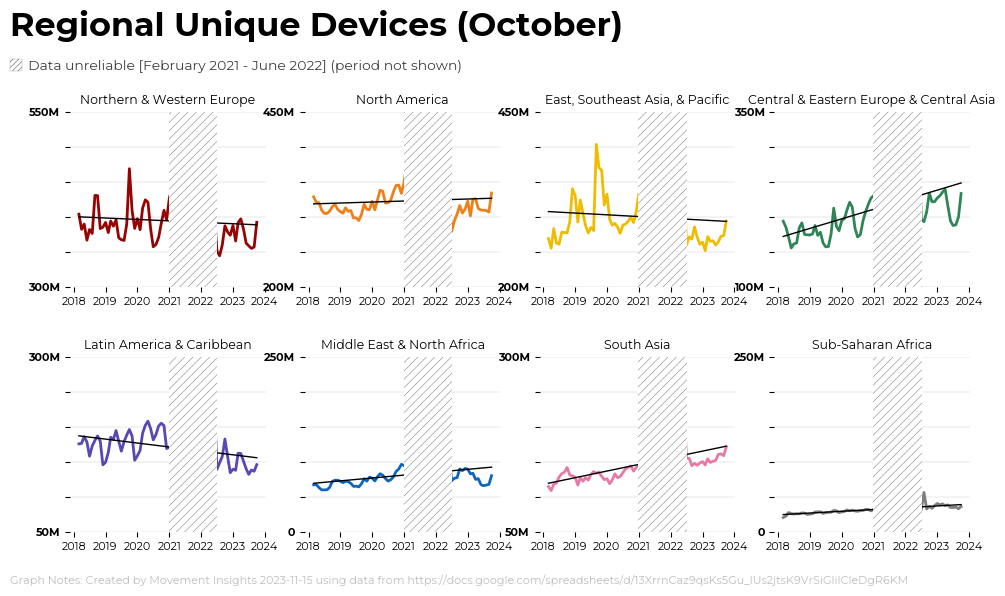

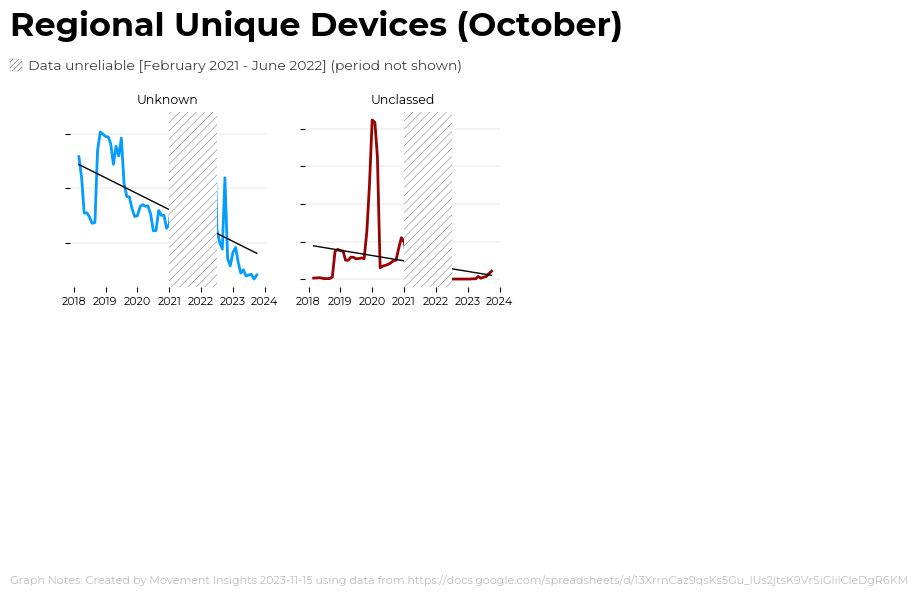

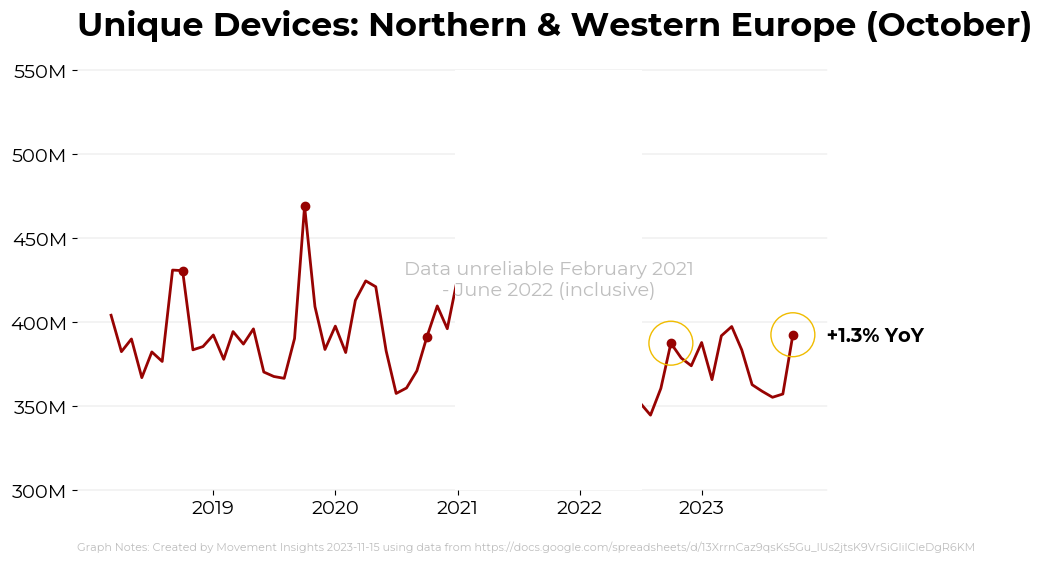

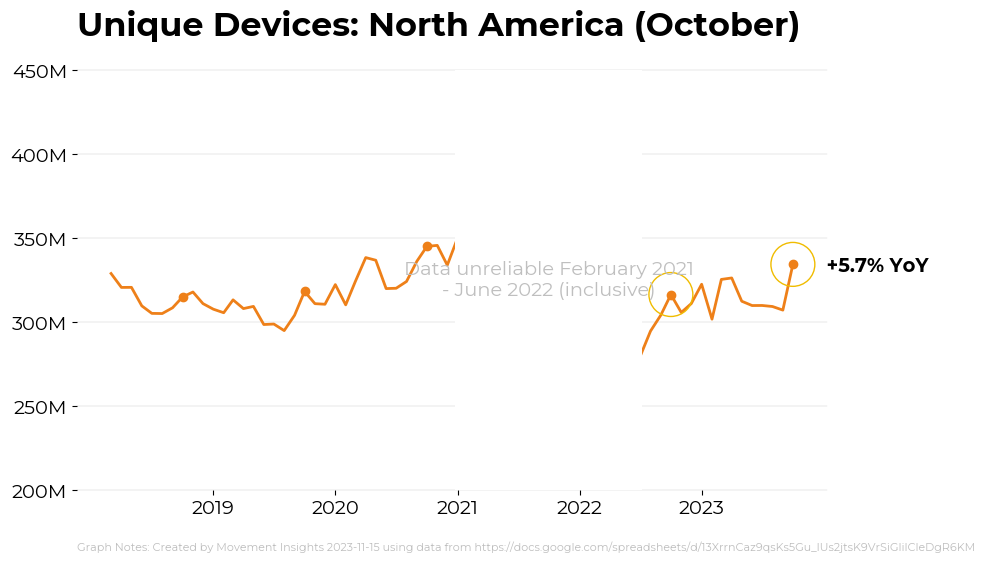

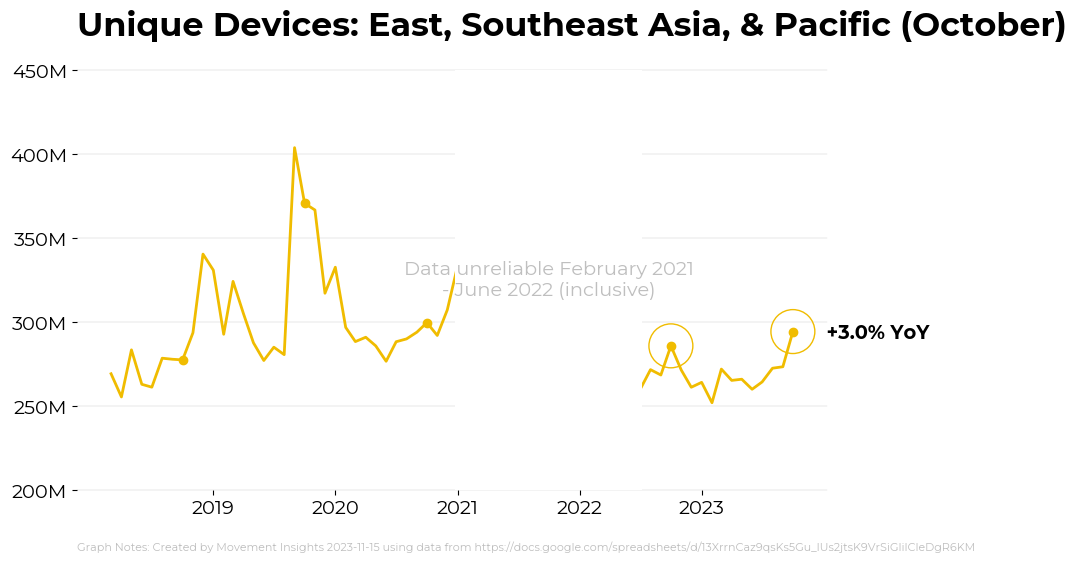

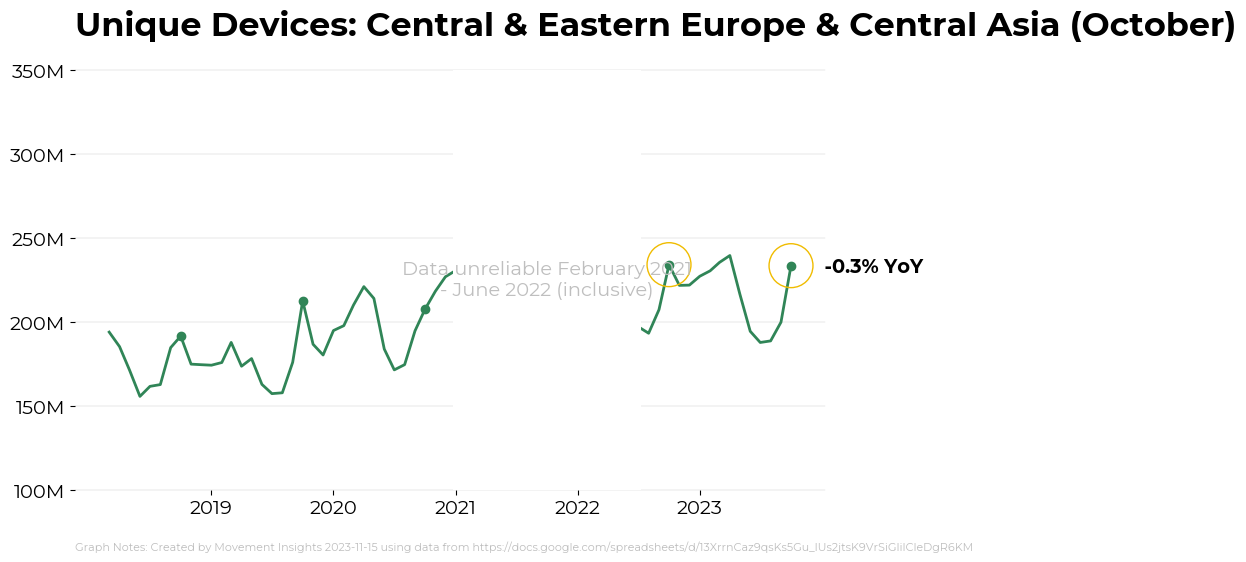

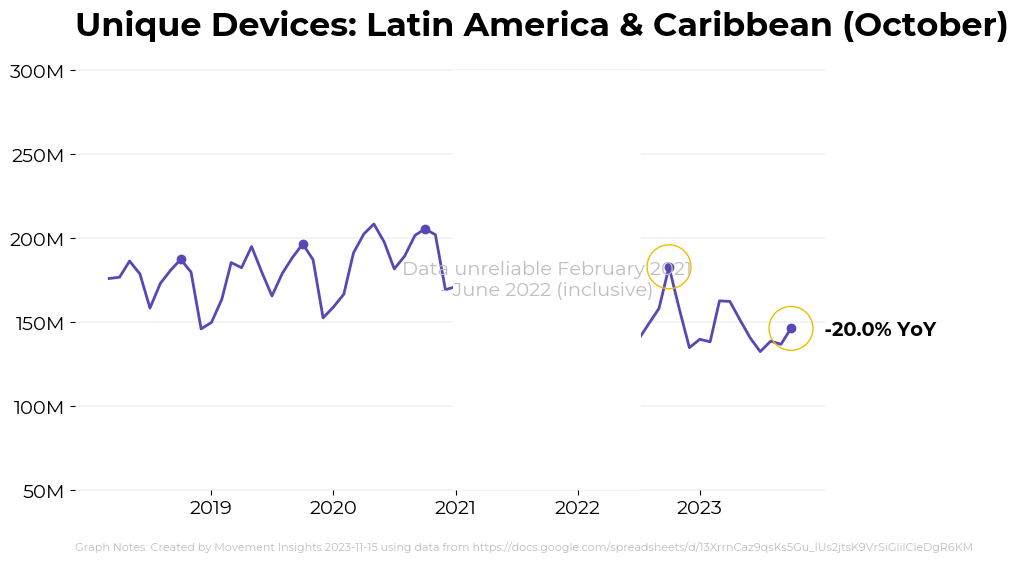

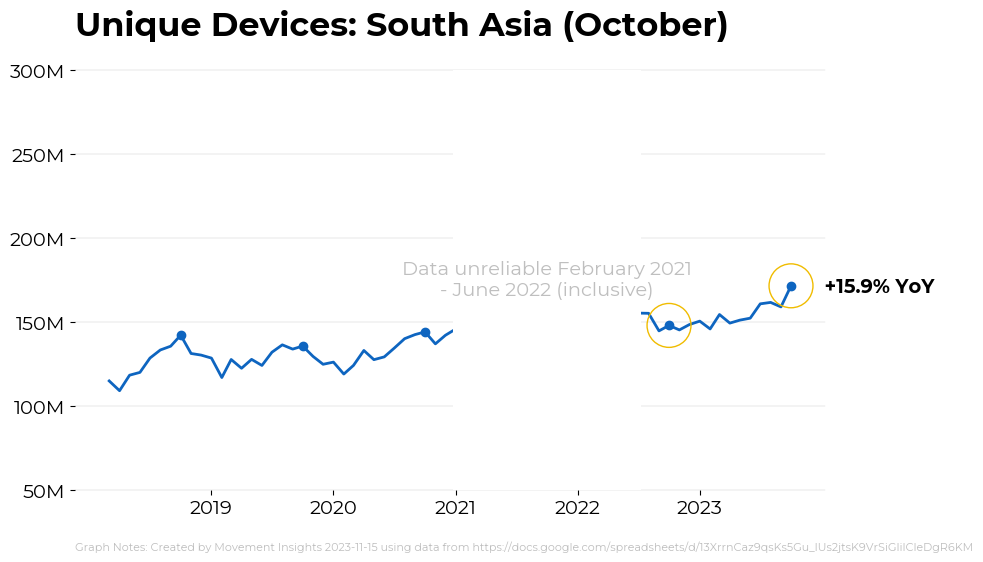

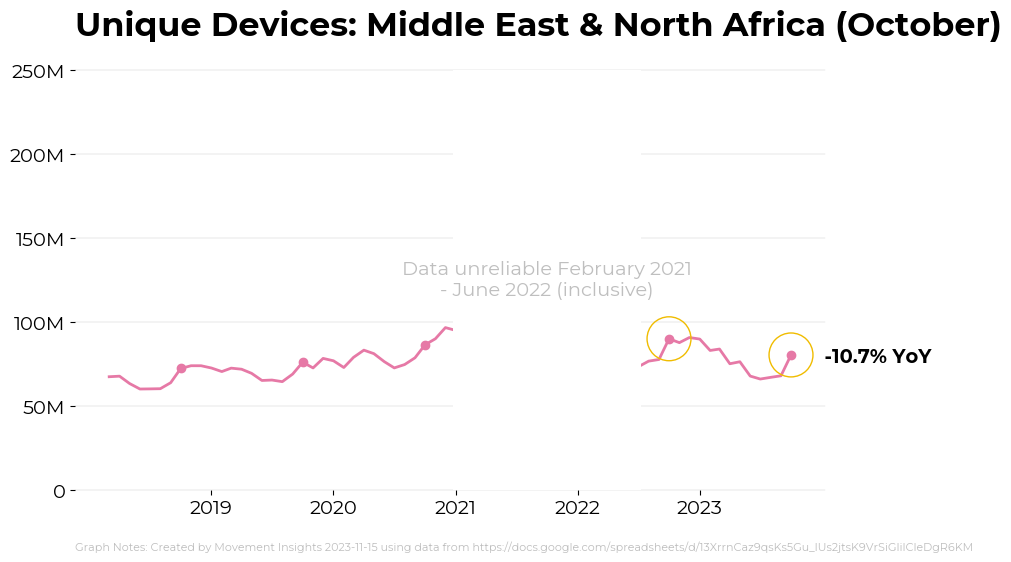

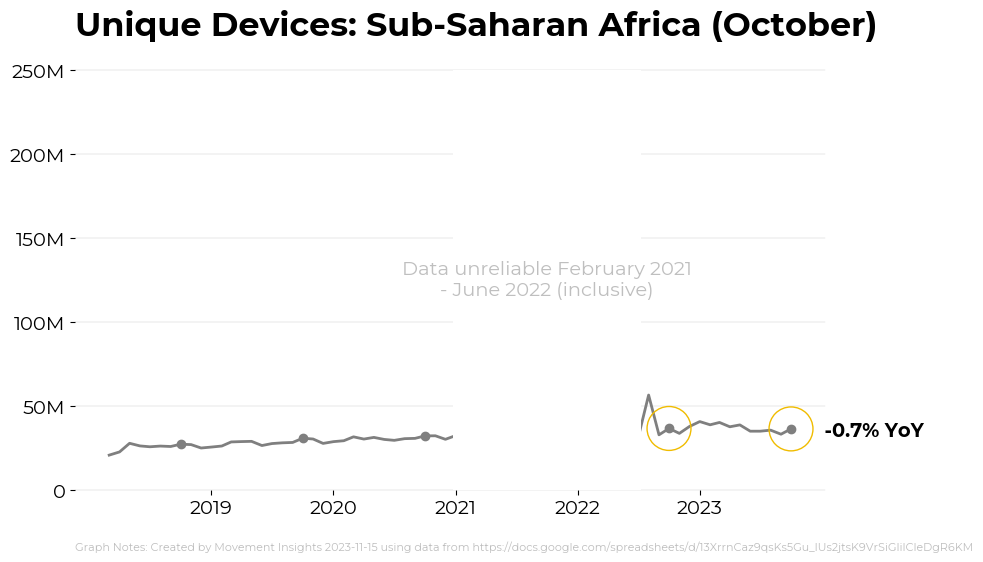

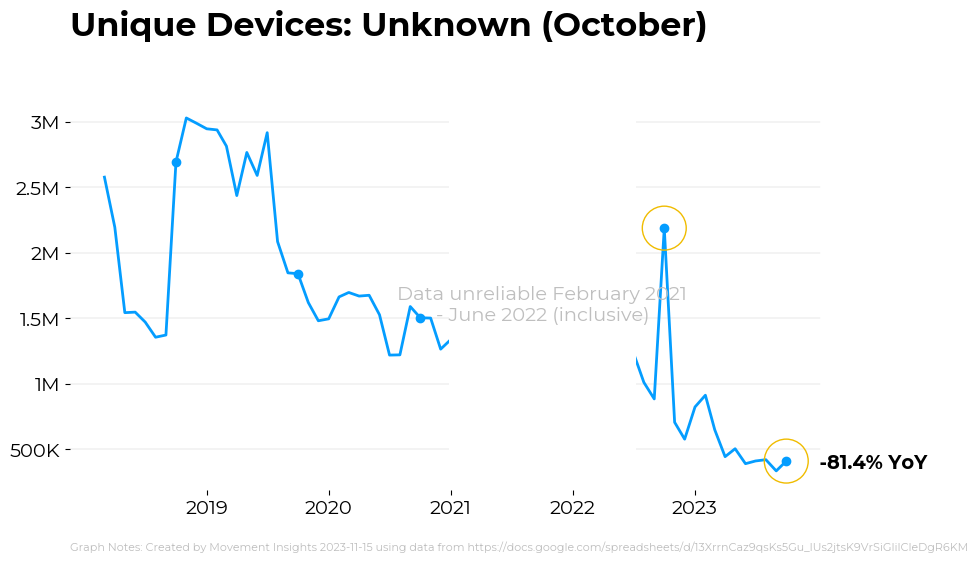

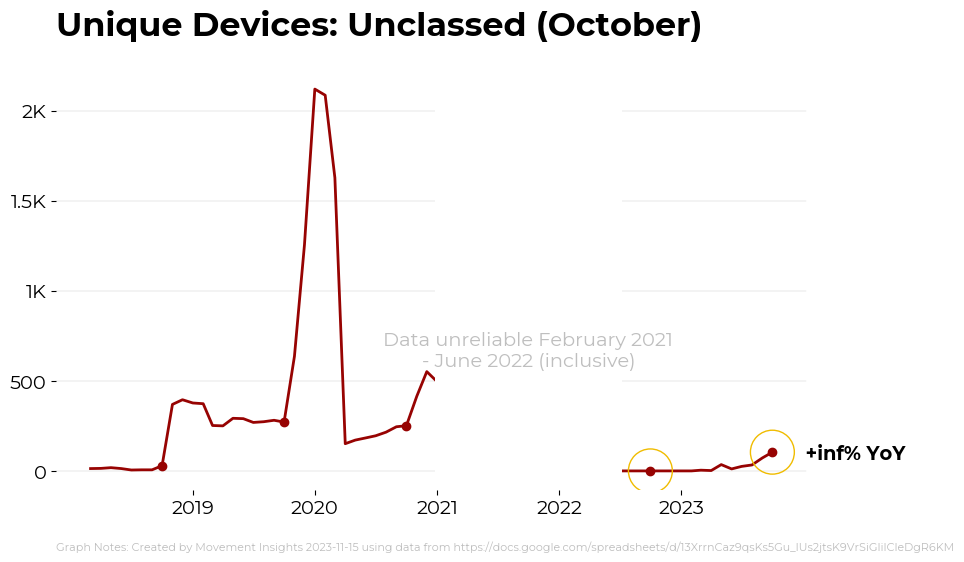

Generating Active Editors chart...


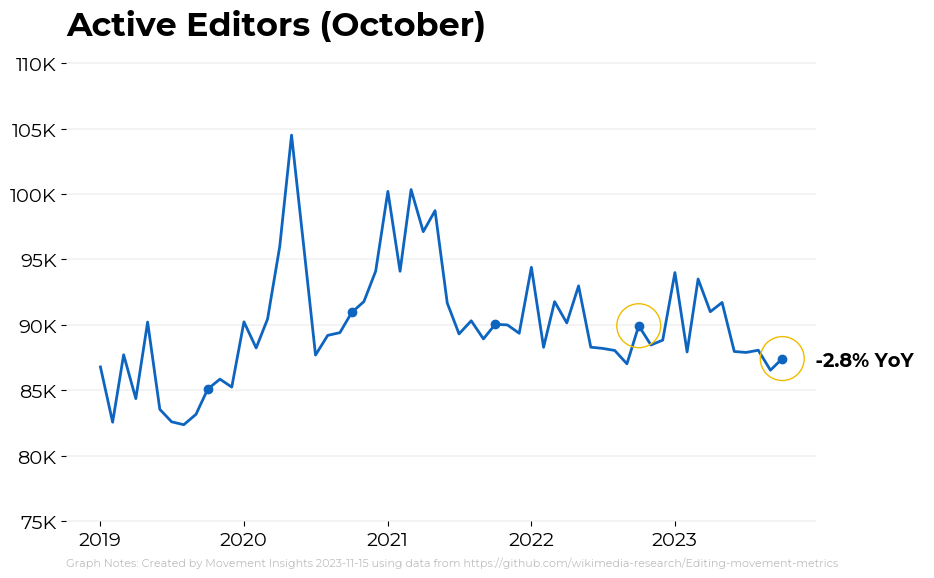

Generating New Returning chart...


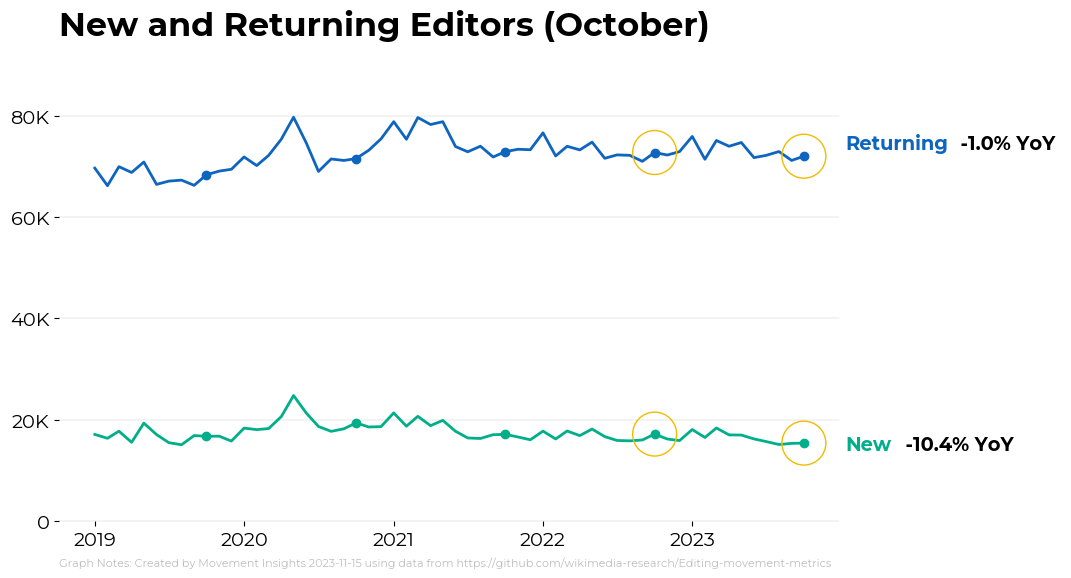

Generating Net New Content chart...


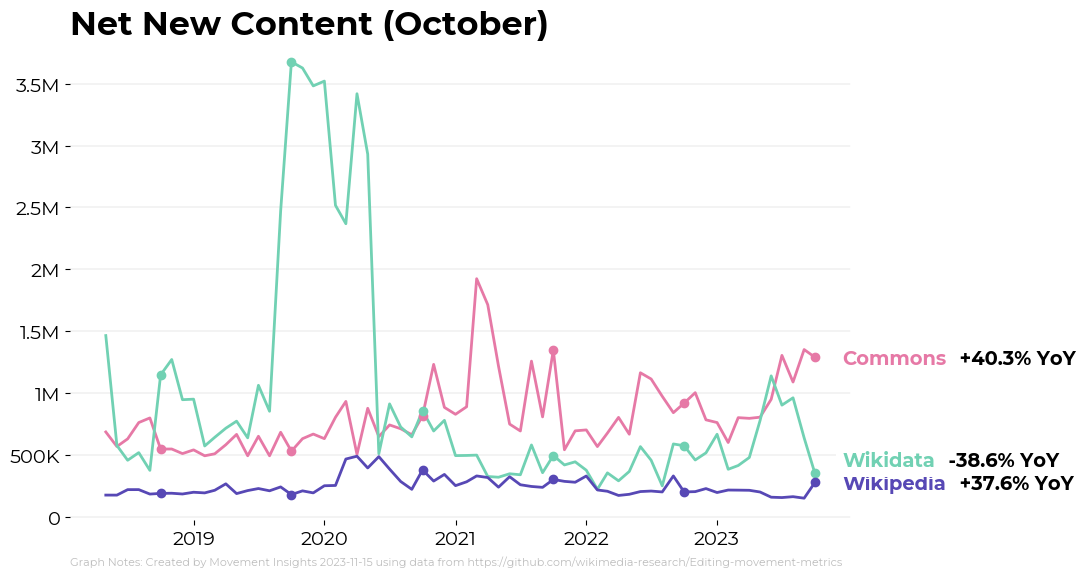

Resetting directory to:/srv/home/hghani/2023-11-08/wikicharts


In [29]:
%run "wikicharts/CORE_AND_ESSENTIAL_METRICS.ipynb"